In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import os
import numpy as np
import itertools

In [2]:
#Covid Tracking project API
#this works interimittentently presumably due to load on their servers
#@todo wrap function with a retry decorator

daily = pd.read_json("https://covidtracking.com/api/states/daily", orient='records')
daily

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked
0,20200324,AK,36.0,986.0,NaN,0.0,NaN,1022,2020-03-24T20:00:00Z
1,20200324,AL,215.0,2106.0,NaN,NaN,0.0,2321,2020-03-24T20:00:00Z
2,20200324,AR,218.0,947.0,0.0,22.0,0.0,1165,2020-03-24T20:00:00Z
3,20200324,AS,0.0,NaN,NaN,NaN,0.0,0,2020-03-24T20:00:00Z
4,20200324,AZ,357.0,313.0,22.0,8.0,5.0,692,2020-03-24T20:00:00Z
...,...,...,...,...,...,...,...,...,...
1032,20200304,OR,3.0,29.0,18.0,NaN,NaN,50,2020-03-04T21:00:00Z
1033,20200304,SC,0.0,5.0,0.0,NaN,NaN,5,2020-03-04T21:00:00Z
1034,20200304,TX,1.0,NaN,NaN,NaN,NaN,1,2020-03-04T21:00:00Z
1035,20200304,WA,39.0,NaN,NaN,NaN,NaN,39,2020-03-04T21:00:00Z


In [3]:
states = pd.read_json("https://covidtracking.com/api/states", orient='records')

In [4]:
states.set_index("state", drop=True).loc["NY"]

positive                               25665
positiveScore                              1
negativeScore                              1
negativeRegularScore                       0
commercialScore                            1
grade                                      B
score                                      3
negative                               65605
pending                                  NaN
hospitalized                            3234
death                                    210
total                                  91270
lastUpdateEt                      3/24 11:30
checkTimeEt                       3/24 15:28
dateModified            2020-03-24T15:30:00Z
dateChecked             2020-03-24T19:28:00Z
Name: NY, dtype: object

In [5]:
population = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")

In [6]:
population.loc[population["Country Name"].str.contains("Italy")].tail(1)

,Country Name,Country Code,Year,Value
8088,Italy,ITA,2016,60600590.0


In [7]:
daily.date = daily.date.astype("str").apply(pd.to_datetime).dt.date

In [8]:
daily = daily.set_index(["state","date"], drop=True).sort_index()

In [9]:
daily_test_rate = (daily['total']-daily["total"].shift(1))
daily_test_rate.name = "daily_test"
daily = pd.concat([daily, daily_test_rate], axis=1)

In [10]:
daily

positive  negative  pending  hospitalized  death  total  \
state date                                                                  
AK    2020-03-06       0.0       8.0      1.0           NaN    NaN      9   
      2020-03-07       0.0      12.0      2.0           NaN    NaN     14   
      2020-03-08       0.0      14.0      6.0           NaN    NaN     20   
      2020-03-09       0.0      23.0      9.0           NaN    NaN     32   
      2020-03-10       0.0      23.0      9.0           NaN    NaN     32   
...                    ...       ...      ...           ...    ...    ...   
WY    2020-03-20      19.0     331.0      NaN           NaN    NaN    350   
      2020-03-21      23.0     438.0      NaN           NaN    NaN    461   
      2020-03-22      24.0     438.0      NaN           NaN    NaN    462   
      2020-03-23      26.0     592.0      NaN           NaN    NaN    618   
      2020-03-24      29.0     710.0      NaN           NaN    NaN    739   

                           dateChecked  daily_test  
state date                                          
AK    2020-03-06  2020-03-06T21:00:00Z         NaN  
      2020-03-07  2020-03-07T21:00:00Z         5.0  
      2020-03-08  2020-03-08T20:00:00Z         6.0  
      2020-03-09  2020-03-09T20:00:00Z        12.0  
      2020-03-10  2020-03-10T20:00:00Z         0.0  
...                                ...         ...  
WY    2020-03-20  2020-03-20T20:00:00Z        61.0  
      2020-03-21  2020-03-21T20:00:00Z       111.0  
      2020-03-22  2020-03-22T20:00:00Z         1.0  
      2020-03-23  2020-03-23T20:00:00Z       156.0  
      2020-03-24  2020-03-24T20:00:00Z       121.0  

[1037 rows x 8 columns]

In [11]:
daily_last_update = daily.index.get_level_values(1).max().date().strftime("%Y-%m-%d")

In [12]:
# need to develop a "days since tests scaled" index using either daily rates or use worldindata upper half pop adjusted data
# this file must be manually updated from this page:  https://ourworldindata.org/covid-testing  (per million data)
file = "tests-vs-confirmed-cases-covid-19-per-million.csv"
folder = "c:/users/lee/downloads"
tests_world = pd.read_csv(os.path.join(folder, file))

In [13]:
tests_world_sum = tests_world.dropna(subset=["Total COVID-19 tests per million people", \
                           "Total confirmed cases of COVID-19 per million people (cases per million)"]).\
        groupby("Entity").last()
cols = list(tests_world_sum.columns)
new_cols = ["tests_per_M", "cases_per_M"]
cols = cols[0:2]+ new_cols
tests_world_sum.columns = cols

In [14]:
world_tests_cum_median = tests_world_sum['tests_per_M'].describe()["50%"]
world_tests_cum_median

#use this as benchmark for "scale" testing

602.4000000000001

In [15]:
tests_world_sum

,Code,Year,tests_per_M,cases_per_M
Entity,,,,
Armenia,ARM,57,276.7,26.322592
Australia,AUS,59,4473.4,27.804051
Austria,AUT,59,1777.8,243.826612
Bahrain,BHR,59,10982.1,158.088086
Belarus,BLR,55,1699.3,2.857348
Belgium,BEL,57,1580.0,107.251181
Brazil,BRA,52,13.7,0.362252
Canada,CAN,59,3389.7,22.415253
Colombia,COL,59,81.7,2.515581


In [16]:
cols

['Code', 'Year', 'tests_per_M', 'cases_per_M']

In [17]:
pop = pd.read_csv("http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#")

In [18]:
pop

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0,0,0,United States,308745538,308758105,309321666,311556874,313830990,...,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1,0,0,Northeast Region,55317240,55318443,55380134,55604223,55775216,...,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
2,20,2,0,0,Midwest Region,66927001,66929725,66974416,67157800,67336743,...,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
3,20,3,0,0,South Region,114555744,114563030,114866680,116006522,117241208,...,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
4,20,4,0,0,West Region,71945553,71946907,72100436,72788329,73477823,...,0.614245,2.723344,3.062896,3.162262,4.026429,4.987285,5.261078,4.021194,3.044951,2.312083
5,40,3,6,1,Alabama,4779736,4780125,4785437,4799069,4815588,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
6,40,4,9,2,Alaska,710231,710249,713910,722128,730443,...,-12.929847,0.587728,1.416798,-0.955359,-11.460949,-7.997118,-3.897349,-10.992765,-13.859140,-12.031221
7,40,4,8,4,Arizona,6392017,6392288,6407172,6472643,6554978,...,12.609078,4.278167,6.899802,6.376679,9.168478,9.597577,11.964782,10.878879,12.962934,13.687161
8,40,3,7,5,Arkansas,2915918,2916031,2921964,2940667,2952164,...,0.834503,3.294766,0.827785,0.057853,-0.091449,1.075446,1.486269,2.009593,0.958896,0.923429
9,40,4,9,6,California,37253956,37254519,37319502,37638369,37948800,...,-5.151429,1.276797,1.495016,1.649031,2.203551,1.984957,0.500044,-0.629909,-2.130954,-3.276681


In [19]:
key_cols = ['STATE', 'NAME', 'POPESTIMATE2019']
pop_19 = pop[key_cols].set_index(["STATE", "NAME"], drop=True)
pop_19

POPESTIMATE2019
STATE NAME                                 
0     United States               328239523
      Northeast Region             55982803
      Midwest Region               68329004
      South Region                125580448
      West Region                  78347268
1     Alabama                       4903185
2     Alaska                         731545
4     Arizona                       7278717
5     Arkansas                      3017804
6     California                   39512223
8     Colorado                      5758736
9     Connecticut                   3565287
10    Delaware                       973764
11    District of Columbia           705749
12    Florida                      21477737
13    Georgia                      10617423
15    Hawaii                        1415872
16    Idaho                         1787065
17    Illinois                     12671821
18    Indiana                       6732219
19    Iowa                          3155070
20    Kansas                        2913314
21    Kentucky                      4467673
22    Louisiana                     4648794
23    Maine                         1344212
24    Maryland                      6045680
25    Massachusetts                 6892503
26    Michigan                      9986857
27    Minnesota                     5639632
28    Mississippi                   2976149
29    Missouri                      6137428
30    Montana                       1068778
31    Nebraska                      1934408
32    Nevada                        3080156
33    New Hampshire                 1359711
34    New Jersey                    8882190
35    New Mexico                    2096829
36    New York                     19453561
37    North Carolina               10488084
38    North Dakota                   762062
39    Ohio                         11689100
40    Oklahoma                      3956971
41    Oregon                        4217737
42    Pennsylvania                 12801989
44    Rhode Island                  1059361
45    South Carolina                5148714
46    South Dakota                   884659
47    Tennessee                     6829174
48    Texas                        28995881
49    Utah                          3205958
50    Vermont                        623989
51    Virginia                      8535519
53    Washington                    7614893
54    West Virginia                 1792147
55    Wisconsin                     5822434
56    Wyoming                        578759
72    Puerto Rico                   3193694

In [20]:
states_abbrev = pd.read_json("https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_titlecase.json")

In [21]:
states_abbrev

,name,abbreviation
0,Alabama,AL
1,Alaska,AK
2,American Samoa,AS
3,Arizona,AZ
4,Arkansas,AR
5,California,CA
6,Colorado,CO
7,Connecticut,CT
8,Delaware,DE
9,District Of Columbia,DC


In [22]:
pop_19 = pop_19.reset_index(0).join(states_abbrev.set_index('name')).set_index("abbreviation")
pop_19

,STATE,POPESTIMATE2019
abbreviation,,
NaN,0,328239523
NaN,0,55982803
NaN,0,68329004
NaN,0,125580448
NaN,0,78347268
AL,1,4903185
AK,2,731545
AZ,4,7278717
AR,5,3017804


In [23]:
pop_19 = pop_19.loc[pop_19.index.dropna()]
pop_19

,STATE,POPESTIMATE2019
abbreviation,,
AL,1,4903185
AK,2,731545
AZ,4,7278717
AR,5,3017804
CA,6,39512223
CO,8,5758736
CT,9,3565287
DE,10,973764
FL,12,21477737


In [24]:
daily = daily.reset_index().join(pop_19, on="state", how = 'inner').set_index(['state', 'date'], drop=True).sort_index()
daily

positive  negative  pending  hospitalized  death  total  \
state date                                                                  
AK    2020-03-06       0.0       8.0      1.0           NaN    NaN      9   
      2020-03-07       0.0      12.0      2.0           NaN    NaN     14   
      2020-03-08       0.0      14.0      6.0           NaN    NaN     20   
      2020-03-09       0.0      23.0      9.0           NaN    NaN     32   
      2020-03-10       0.0      23.0      9.0           NaN    NaN     32   
...                    ...       ...      ...           ...    ...    ...   
WY    2020-03-20      19.0     331.0      NaN           NaN    NaN    350   
      2020-03-21      23.0     438.0      NaN           NaN    NaN    461   
      2020-03-22      24.0     438.0      NaN           NaN    NaN    462   
      2020-03-23      26.0     592.0      NaN           NaN    NaN    618   
      2020-03-24      29.0     710.0      NaN           NaN    NaN    739   

                           dateChecked  daily_test  STATE  POPESTIMATE2019  
state date                                                                  
AK    2020-03-06  2020-03-06T21:00:00Z         NaN      2           731545  
      2020-03-07  2020-03-07T21:00:00Z         5.0      2           731545  
      2020-03-08  2020-03-08T20:00:00Z         6.0      2           731545  
      2020-03-09  2020-03-09T20:00:00Z        12.0      2           731545  
      2020-03-10  2020-03-10T20:00:00Z         0.0      2           731545  
...                                ...         ...    ...              ...  
WY    2020-03-20  2020-03-20T20:00:00Z        61.0     56           578759  
      2020-03-21  2020-03-21T20:00:00Z       111.0     56           578759  
      2020-03-22  2020-03-22T20:00:00Z         1.0     56           578759  
      2020-03-23  2020-03-23T20:00:00Z       156.0     56           578759  
      2020-03-24  2020-03-24T20:00:00Z       121.0     56           578759  

[981 rows x 10 columns]

In [25]:
daily.loc["NY"]

,positive,negative,pending,hospitalized,death,total,dateChecked,daily_test,STATE,POPESTIMATE2019
date,,,,,,,,,,
2020-03-04,6.0,48.0,24.0,NaN,NaN,78,2020-03-04T21:00:00Z,-4154.0,36,19453561
2020-03-05,22.0,76.0,24.0,NaN,NaN,122,2020-03-05T21:00:00Z,44.0,36,19453561
2020-03-06,33.0,92.0,236.0,NaN,NaN,361,2020-03-06T21:00:00Z,239.0,36,19453561
2020-03-07,76.0,92.0,236.0,NaN,NaN,404,2020-03-07T21:00:00Z,43.0,36,19453561
2020-03-08,105.0,92.0,NaN,NaN,NaN,197,2020-03-08T20:00:00Z,-207.0,36,19453561
2020-03-09,142.0,92.0,NaN,NaN,NaN,234,2020-03-09T20:00:00Z,37.0,36,19453561
2020-03-10,173.0,92.0,NaN,NaN,NaN,265,2020-03-10T20:00:00Z,31.0,36,19453561
2020-03-11,216.0,NaN,NaN,NaN,NaN,216,2020-03-11T20:00:00Z,-49.0,36,19453561
2020-03-12,216.0,NaN,NaN,NaN,NaN,216,2020-03-12T20:00:00Z,0.0,36,19453561


In [26]:
daily.daily_test.sum()

16117.0

In [27]:
daily_per_capita_M = daily[['positive', 'negative', 'pending', 'death', 'total', 'daily_test']].div(daily.POPESTIMATE2019/1000000
                                                                 , axis=0)
daily_per_capita_M

positive     negative    pending  death        total  \
state date                                                                
AK    2020-03-06   0.000000    10.935759   1.366970    NaN    12.302729   
      2020-03-07   0.000000    16.403639   2.733940    NaN    19.137579   
      2020-03-08   0.000000    19.137579   8.201819    NaN    27.339398   
      2020-03-09   0.000000    31.440308  12.302729    NaN    43.743037   
      2020-03-10   0.000000    31.440308  12.302729    NaN    43.743037   
...                     ...          ...        ...    ...          ...   
WY    2020-03-20  32.828863   571.913353        NaN    NaN   604.742216   
      2020-03-21  39.740203   756.791687        NaN    NaN   796.531890   
      2020-03-22  41.468038   756.791687        NaN    NaN   798.259725   
      2020-03-23  44.923707  1022.878262        NaN    NaN  1067.801969   
      2020-03-24  50.107212  1226.762780        NaN    NaN  1276.869993   

                  daily_test  
state date                    
AK    2020-03-06         NaN  
      2020-03-07    6.834850  
      2020-03-08    8.201819  
      2020-03-09   16.403639  
      2020-03-10    0.000000  
...                      ...  
WY    2020-03-20  105.397929  
      2020-03-21  191.789674  
      2020-03-22    1.727835  
      2020-03-23  269.542245  
      2020-03-24  209.068023  

[981 rows x 6 columns]

In [28]:
daily_per_capita_M["rolling_test_3d"] = daily_per_capita_M.groupby(level=0).rolling(3).mean()['daily_test'].\
    reset_index(0, drop=True)

In [29]:
daily_limit = 200 # 200/M was rate at which South Korea hit after ramping testing.   
cum_mask = daily_per_capita_M["total"]>=world_tests_cum_median
daily_mask = daily_per_capita_M['rolling_test_3d'] >=daily_limit
daily_per_capita_M["bool"] = daily_mask | cum_mask
daily_per_capita_M

positive     negative    pending  death        total  \
state date                                                                
AK    2020-03-06   0.000000    10.935759   1.366970    NaN    12.302729   
      2020-03-07   0.000000    16.403639   2.733940    NaN    19.137579   
      2020-03-08   0.000000    19.137579   8.201819    NaN    27.339398   
      2020-03-09   0.000000    31.440308  12.302729    NaN    43.743037   
      2020-03-10   0.000000    31.440308  12.302729    NaN    43.743037   
...                     ...          ...        ...    ...          ...   
WY    2020-03-20  32.828863   571.913353        NaN    NaN   604.742216   
      2020-03-21  39.740203   756.791687        NaN    NaN   796.531890   
      2020-03-22  41.468038   756.791687        NaN    NaN   798.259725   
      2020-03-23  44.923707  1022.878262        NaN    NaN  1067.801969   
      2020-03-24  50.107212  1226.762780        NaN    NaN  1276.869993   

                  daily_test  rolling_test_3d   bool  
state date                                            
AK    2020-03-06         NaN              NaN  False  
      2020-03-07    6.834850              NaN  False  
      2020-03-08    8.201819              NaN  False  
      2020-03-09   16.403639        10.480103  False  
      2020-03-10    0.000000         8.201819  False  
...                      ...              ...    ...  
WY    2020-03-20  105.397929       141.106517   True  
      2020-03-21  191.789674       154.353251   True  
      2020-03-22    1.727835        99.638479   True  
      2020-03-23  269.542245       154.353251   True  
      2020-03-24  209.068023       160.112701   True  

[981 rows x 8 columns]

In [30]:
def ret_ndx(s):
    if s.any():
        n = s.shape[0]
        ndx = s.idxmax()
        ptr = s.index.get_loc(ndx)
        arr = list(np.arange(0, n-ptr))
        fill_len = n- len(arr)
        fill = [None]*fill_len
        fill.extend(arr)
        return pd.Series(fill, s.index)
    else: return pd.Series(index=s.index)
    
    

In [31]:
g = daily_per_capita_M.groupby(level=0)['bool']
new_col = g.apply(ret_ndx)

In [32]:
daily_per_capita_M['test_scale_ndx'] = new_col
daily_per_capita_M.loc["FL"]

,positive,negative,pending,death,total,daily_test,rolling_test_3d,bool,test_scale_ndx
date,,,,,,,,,
2020-03-04,0.093120,1.117436,0.744957,NaN,1.955513,-3.957586,NaN,False,NaN
2020-03-05,0.419039,1.443355,3.212629,NaN,5.075023,3.119509,NaN,False,NaN
2020-03-06,0.419039,2.560791,2.374552,NaN,5.354382,0.279359,-0.186239,False,NaN
2020-03-07,0.651838,4.655984,4.097266,NaN,9.405088,4.050706,2.483191,False,NaN
2020-03-08,0.791517,5.494061,5.028463,NaN,11.314041,1.908953,2.079673,False,NaN
2020-03-09,0.838077,6.518378,5.354382,NaN,12.710836,1.396795,2.452152,False,NaN
2020-03-10,0.884637,10.336284,7.216775,NaN,18.437697,5.726860,3.010870,False,NaN
2020-03-11,1.303676,14.014512,6.844296,0.093120,22.162484,3.724787,3.616148,False,NaN
2020-03-12,1.489915,14.014512,6.844296,0.093120,22.348723,0.186239,3.212629,False,NaN


In [33]:
states_scaling = daily_per_capita_M.reset_index(1)['bool'].groupby(level=0).any()
states_scaling
# states testing at scale levels either cumulatively or on a daily basis

state
AK     True
AL    False
AR    False
AZ    False
CA     True
CO     True
CT     True
DE    False
FL     True
GA    False
HI     True
IA     True
ID     True
IL     True
IN    False
KS     True
KY    False
LA     True
MA     True
MD    False
ME     True
MI    False
MN     True
MO    False
MS     True
MT     True
NC     True
ND     True
NE    False
NH     True
NJ     True
NM     True
NV     True
NY     True
OH    False
OK    False
OR     True
PA     True
PR    False
RI     True
SC    False
SD     True
TN     True
TX    False
UT     True
VA    False
VT     True
WA     True
WI     True
WV    False
WY     True
Name: bool, dtype: bool

In [34]:
testing_per_capita = daily_per_capita_M.groupby(level=0).last().\
    sort_values("total", ascending=False)[['total', 'rolling_test_3d']]
testing_per_capita
# south korea scaled up to around 200-300 tests per million people.  200 at scale
# I later realized that total is cumulative.  so, had to add a daily_test delta line.   this is average of last 3 days of tests.

,total,rolling_test_3d
state,,
NY,4691.686011,785.340363
WA,4456.136153,467.942666
NM,2848.587081,340.991087
HI,2589.217104,823.049918
VT,2459.979262,388.361547
ME,2335.197127,198.877360
MA,1994.776063,409.720533
ND,1952.597033,139.533704
LA,1850.587486,418.603190


Text(0.5, 0, 'Total Confirmed Cases of Covid19 Per Million People')

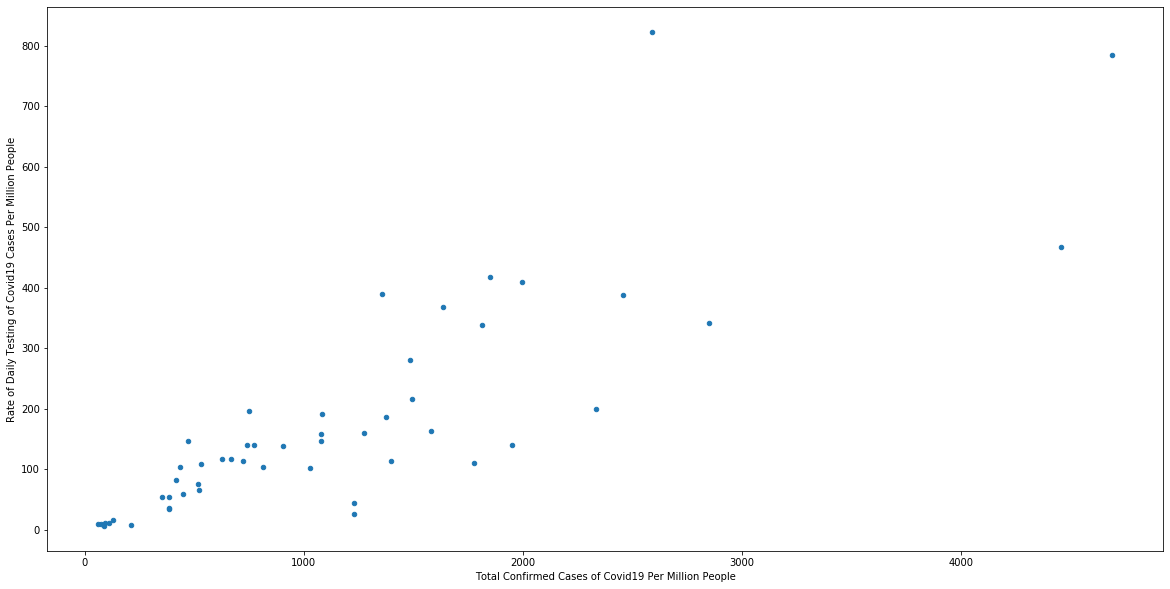

In [35]:
f, ax = plt.subplots(figsize=(20,10))
testing_per_capita.plot.scatter(x='total', y='rolling_test_3d', ax=ax)
ax.set_ylabel("Rate of Daily Testing of Covid19 Cases Per Million People")
ax.set_xlabel("Total Confirmed Cases of Covid19 Per Million People")

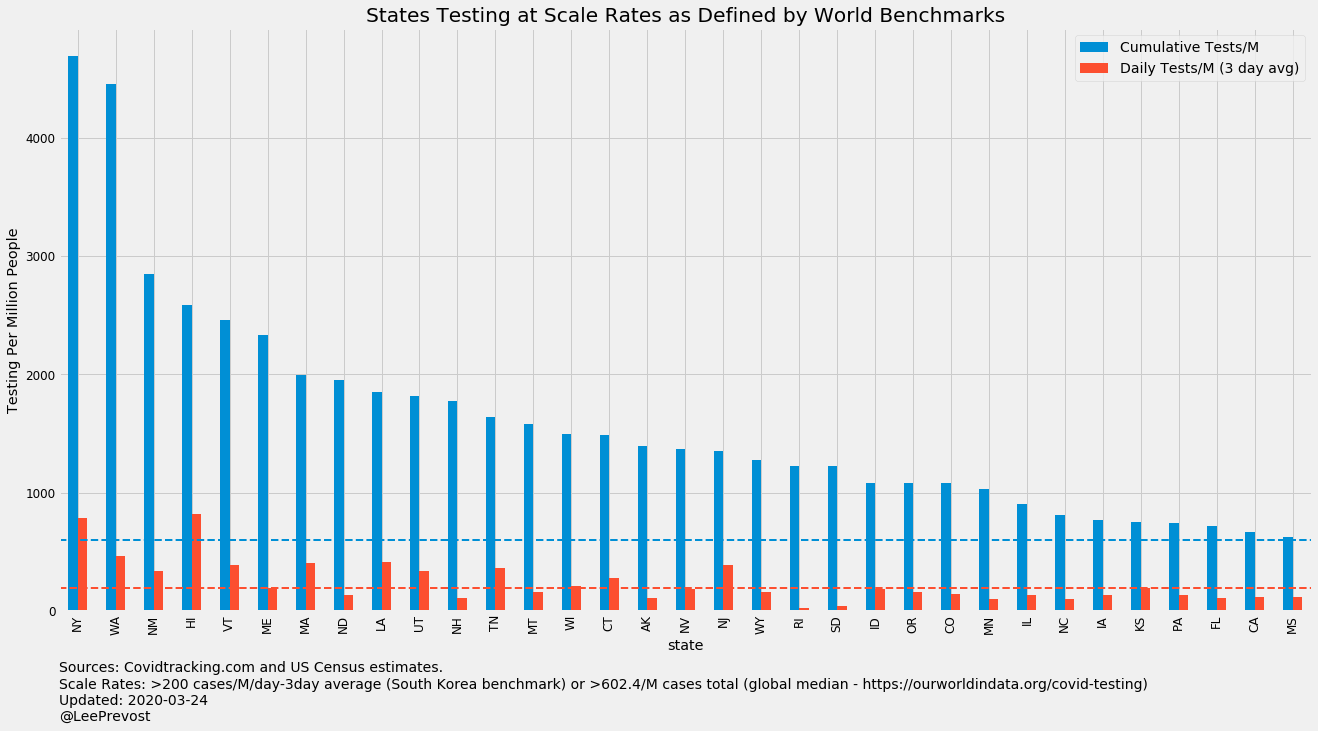

In [54]:
f, ax = plt.subplots(figsize= (20,10))
plt.style.use("fivethirtyeight")
title = "States Testing at Scale Rates as Defined by World Benchmarks"
states_testing_top = testing_per_capita.loc[states_scaling].sort_values(by="total", ascending=False)
ax.set_title(title)
ax.set_ylabel("Testing Per Million People")

label=["Cumulative Tests/M", "Daily Tests/M (3 day avg)"]
states_testing_top.plot(kind='bar', ax=ax, label=label)
colors = colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.legend(label)
lw=2
ax.axhline(world_tests_cum_median, color = colors[0], linestyle='--', linewidth=lw)
ax.axhline(daily_limit,color=colors[1], linestyle="--", linewidth=lw)
note = """Sources: Covidtracking.com and US Census estimates.
Scale Rates: >200 cases/M/day-3day average (South Korea benchmark) or >602.4/M cases total (global median - https://ourworldindata.org/covid-testing)
Updated: {}
@LeePrevost""".format(daily_last_update)
plt.annotate(note, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("{}.jpg".format(title), bbox_inches='tight')

In [38]:

positives = daily_per_capita_M.loc[states_testing_top.index].reset_index().groupby('state').last()['positive']
positives

state
AK      49.210917
CA      43.859846
CO     125.027437
CT     173.338079
FL      65.742494
HI      54.383447
IA      39.301822
ID      27.978837
IL     122.397562
KS      33.638667
LA     298.572060
MA     168.153717
ME      92.991284
MN      46.456932
MS     107.521498
MT      43.039808
NC      37.947827
ND      44.615792
NH      74.280490
NJ     413.749312
NM      39.583581
NV      90.255169
NY    1319.295732
OR      49.552639
PA      66.474046
RI     100.060319
SD      33.911372
TN      97.669206
UT      93.263854
VT     152.246274
WA     291.665293
WI      78.489511
WY      50.107212
Name: positive, dtype: float64

In [39]:
positive = daily_per_capita_M.loc[states_testing_top.index].groupby(level=0).last()['positive'].sort_values(ascending=False)
positive_3d_lag = daily_per_capita_M.loc[states_testing_top.index].groupby(level=0).shift(3).groupby(level=0).last()['positive']

In [40]:
positive_3d_lag

state
AK     19.137579
CA     32.369730
CO     63.034666
CT     54.413572
FL     30.636375
HI     26.132306
IA     21.552612
ID     17.346879
IL     59.896679
KS     18.878844
LA    125.839089
MA     76.169717
ME     54.306910
MN     24.469682
MS     47.040656
MT     18.712960
NC     17.543719
ND     36.742417
NH     40.449772
NJ    149.400092
NM     27.183905
NV     40.257701
NY    532.344695
OR     27.028712
PA     28.979872
RI     62.301708
SD     15.825307
TN     54.325750
UT     42.421017
VT     46.475178
WA    200.134132
WI     48.261603
WY     39.740203
Name: positive, dtype: float64

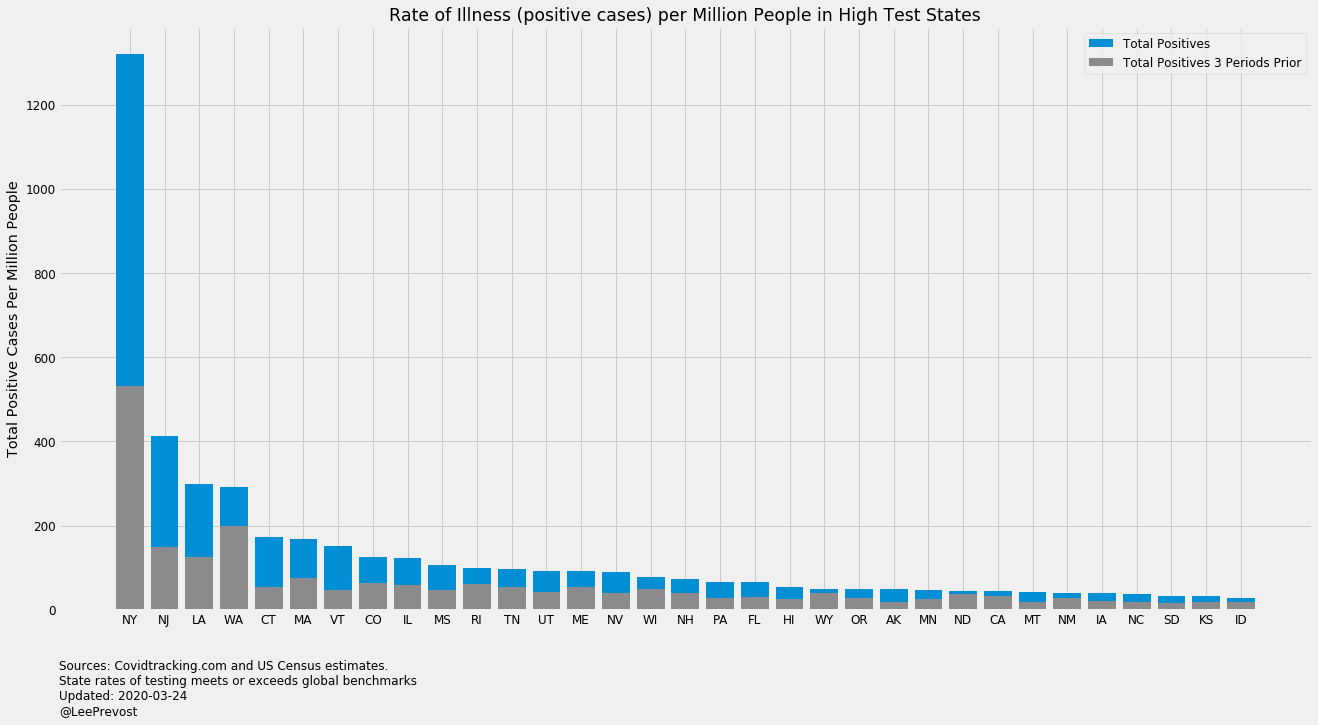

In [53]:
f, ax = plt.subplots(figsize=(20,10))
title = """Rate of Illness (positive cases) per Million People in High Test States"""
ax.bar(positive.index, positive.values)
ax.bar(positive_3d_lag.index, positive_3d_lag.values, color='#8b8b8b')

ax.set_title(title)
ax.set_ylabel("Total Positive Cases Per Million People")
label = ["Total Positives", "Total Positives 3 Periods Prior"]
ax.legend(label)
note = """Sources: Covidtracking.com and US Census estimates.
State rates of testing meets or exceeds global benchmarks
Updated: {}
@LeePrevost""".format(daily_last_update)
plt.annotate(note, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("{}.jpg".format(title), bbox_inches='tight')

In [42]:
colors

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

In [43]:
#pull in South Korea data
path = "csse_covid_19_data/csse_covid_19_time_series/"
Confirmed = "time_series_19-covid-Confirmed.csv"
Deaths = "time_series_19-covid-Deaths.csv"
Recovered = "time_series_19-covid-Recovered.csv"
files = {"Confirmed": Confirmed,
        "Deaths": Deaths,
        "Recovered": Recovered}

for k,v in files.items():
    df = pd.read_csv(os.path.join(path, v))
    files.update({k: df})
    
confirmed= files['Confirmed']
deaths = files['Deaths']
recovered = files['Recovered']
confirmed = confirmed[confirmed["Country/Region"].str.contains("Korea")]
deaths = deaths[deaths["Country/Region"].str.contains("Korea")]
recovered = recovered[recovered["Country/Region"].str.contains("Korea")]
sit_report = pd.concat([confirmed, deaths, recovered], keys = files.keys())
sit_report = sit_report.reset_index().set_index(["Country/Region", 'level_0']).iloc[:, 4:].T
sit_report.index.name = "Day"
ndx = pd.to_datetime(sit_report.index)
sit_report = sit_report.set_index(ndx)

In [44]:
date_start = pd.datetime(2020, 3, 4)   #allows global data to synch with start of US data

In [45]:
confirmed = files['Confirmed']
italy = confirmed[confirmed["Country/Region"].str.contains("Italy")].set_index("Country/Region", drop=True).iloc[:,4:].T
italy.index.name="Day"

italy.name = "Italy"
ndx = pd.to_datetime(italy.index)
italy = italy.set_index(ndx)
italy_pop = italy*1e6/60.5e6
italy_pop = italy_pop.loc[italy_pop.index >= date_start]

In [46]:
italy

Country/Region,Italy
Day,
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
2020-01-27,0
2020-01-28,0
2020-01-29,0
2020-01-30,0
2020-01-31,2


In [47]:
sit_report['population']=51.5e6
sit_report.index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
      

In [48]:
sk_confirmed = sit_report.T.reset_index(0, drop=True).T[['Confirmed', 'Deaths', 'Recovered']].div(sit_report.iloc[:, 3]/1e6, axis=0)['Confirmed']
sk_confirmed = sk_confirmed.to_frame()

In [49]:
sk_confirmed.columns = ["South Korea"]
#limit to US dates
sk_confirmed = sk_confirmed.loc[sk_confirmed.index>= date_start]
sk_confirmed

,South Korea
Day,
2020-03-04,109.145631
2020-03-05,118.213592
2020-03-06,128.019417
2020-03-07,136.718447
2020-03-08,142.019417
2020-03-09,145.203883
2020-03-10,145.883495
2020-03-11,150.582524
2020-03-12,152.796117


In [50]:
daily_per_capita_M.replace(0,pd.np.nan)

positive     negative    pending  death        total  \
state date                                                                
AK    2020-03-06        NaN    10.935759   1.366970    NaN    12.302729   
      2020-03-07        NaN    16.403639   2.733940    NaN    19.137579   
      2020-03-08        NaN    19.137579   8.201819    NaN    27.339398   
      2020-03-09        NaN    31.440308  12.302729    NaN    43.743037   
      2020-03-10        NaN    31.440308  12.302729    NaN    43.743037   
...                     ...          ...        ...    ...          ...   
WY    2020-03-20  32.828863   571.913353        NaN    NaN   604.742216   
      2020-03-21  39.740203   756.791687        NaN    NaN   796.531890   
      2020-03-22  41.468038   756.791687        NaN    NaN   798.259725   
      2020-03-23  44.923707  1022.878262        NaN    NaN  1067.801969   
      2020-03-24  50.107212  1226.762780        NaN    NaN  1276.869993   

                  daily_test  rolling_test_3d   bool  test_scale_ndx  
state date                                                            
AK    2020-03-06         NaN              NaN  False             NaN  
      2020-03-07    6.834850              NaN  False             NaN  
      2020-03-08    8.201819              NaN  False             NaN  
      2020-03-09   16.403639        10.480103  False             NaN  
      2020-03-10         NaN         8.201819  False             NaN  
...                      ...              ...    ...             ...  
WY    2020-03-20  105.397929       141.106517   True             NaN  
      2020-03-21  191.789674       154.353251   True             1.0  
      2020-03-22    1.727835        99.638479   True             2.0  
      2020-03-23  269.542245       154.353251   True             3.0  
      2020-03-24  209.068023       160.112701   True             4.0  

[981 rows x 9 columns]

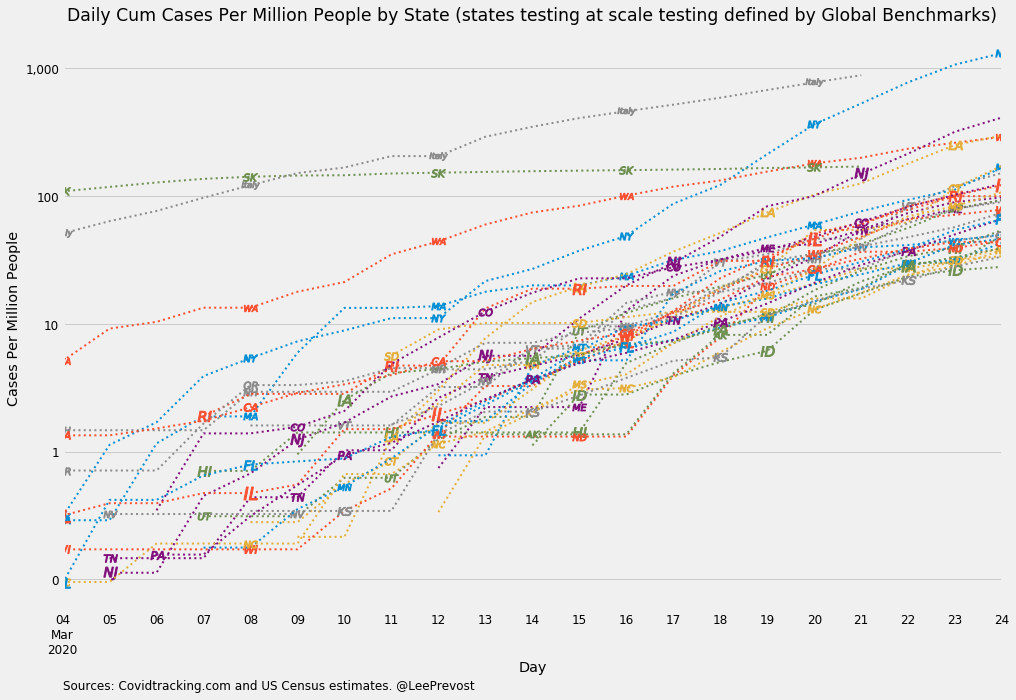

In [58]:

f, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({"font.size": 12})
#plt.style.use("seaborn")
lines = dict(legend=False, markersize=14, ax=ax, linewidth=2, markevery=4, logy=True, linestyle='dotted')

for ndx, state in enumerate(states_testing_top.index):
    daily_per_capita_M.replace(0, pd.np.nan).loc[states_testing_top.index[ndx]]['positive'].\
        plot(label=state, marker='${}$'.format(state), **lines)
    
sk_confirmed.plot(label="South Korea", marker='$SK$', **lines)
lines.pop("markersize")
italy_pop.plot(label="Italy", marker='$Italy$', markersize=18, **lines)
ax.set_ylabel("Cases Per Million People")
note = """Sources: Covidtracking.com and US Census estimates. @LeePrevost"""
plt.annotate(note, (0,0), (0, -70), xycoords='axes fraction', textcoords='offset points', va='top')
title = "Daily Cum Cases Per Million People by State (states testing at scale testing defined by Global Benchmarks)"
plt.title(title)
ax.get_yaxis().set_major_formatter(
    tick.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("{}.jpg".format(title), bbox_inches='tight')